# Imports

In [1]:
!pip install -q catboost ipywidgets
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

import ipywidgets

import os

plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_rows', 500)

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Metrics

In [2]:
import typing
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true, y_pred, isLog=False) -> float:
    if isLog:
        y_pred = np.exp(y_pred)
        y_true = np.exp(y_true)
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

def metrics_stat(y_true: np.array, y_pred: np.array) -> typing.Dict[str,float]:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    raif_metric = deviation_metric(y_true, y_pred)
    return {'mape':mape, 'mdape':mdape, 'rmse': rmse, 'r2': r2, 'raif_metric':raif_metric}

EPS = 1e-8
assert deviation_metric(np.array([1,2,3,4,5]),np.array([1,2,3,4,5])) <= EPS
assert deviation_metric(np.array([1,2,3,4,5]),np.array([0.9,1.8,2.7,3.6,4.5])) <= EPS
assert deviation_metric(np.array([1,2,3,4,5]),np.array([1.1,2.2,3.3,4.4,5.5])) <= EPS
assert deviation_metric(np.array([1,2,3,4,5]),np.array([1.15,2.3,3.45,4.6,5.75])) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([1.3,2.6,3.9,5.2,6.5]))-1) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([0.7,1.4,2.1,2.8,3.5]))-1*NEGATIVE_WEIGHT) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([10,20,30,40,50]))-9) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([0,0,0,0,0]))-9*NEGATIVE_WEIGHT) <= EPS
assert np.abs(deviation_metric(np.array([1,2,3,4,5]),np.array([1,2.2,3.3,5,50])) - 85/45) <= EPS

# Load data


In [3]:
starting_data = pd.read_csv('data/train.csv', index_col='id')

C:\Users\ukhin\.conda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
starting_data = starting_data.reindex(columns=sorted(starting_data.columns))

# Features

### drop some features 

In [5]:
df_DateOut = starting_data.drop(['date'], axis = 1)

### make feature from 'floor' column 

In [6]:
def set_floor(str):
    ans = []
    try:
        s = float(str)
        if s<0:
            return '-1'
        if s == 1:
            return '1'
        if s==2:
            return '2'
        if s<5:
            return '3'
        if s<10:
            return '4'
        if s<20:
            return '5'
        if s<50:
            return '6'
        if s<90:
            return '7'
        else:
            return '0'
        
    except:
        if 'подвал' in str.lower() :
            return 'подвал'
        if 'цоколь' in str.lower() :
            return 'цоколь'
        else:
            return 'uknown'

In [7]:
df_CatFloor_DateOut = df_DateOut
df_CatFloor_DateOut['floor'] = df_CatFloor_DateOut['floor'].apply(str)
df_CatFloor_DateOut['floor'] = df_CatFloor_DateOut['floor'].apply(set_floor)

### categorical features 

In [8]:
cat_features = set([df_CatFloor_DateOut.columns[i] for i in range(len(df_CatFloor_DateOut.dtypes)) if str(df_CatFloor_DateOut.dtypes[i]) not in ['float64','float32', 'int64']])

cat_features.add(df_CatFloor_DateOut.columns[list(df_CatFloor_DateOut.columns).index('realty_type')])
df_CatFloor_DateOut['realty_type']= df_CatFloor_DateOut['realty_type'].apply(str)
cat_features.add(df_CatFloor_DateOut.columns[list(df_CatFloor_DateOut.columns).index('floor')])

cat_features

{'city', 'floor', 'osm_city_nearest_name', 'realty_type', 'region', 'street'}

### dropna 

In [9]:
for col in df_CatFloor_DateOut.columns:
    if col not in cat_features:
        df_CatFloor_DateOut[col] = df_CatFloor_DateOut[col].fillna(df_CatFloor_DateOut[col].median())
    else:
        df_CatFloor_DateOut[col] = df_CatFloor_DateOut[col].fillna('unknown')

### Logarithms

Посмотрим на распределения общей площади площади и цены за квадратный метр

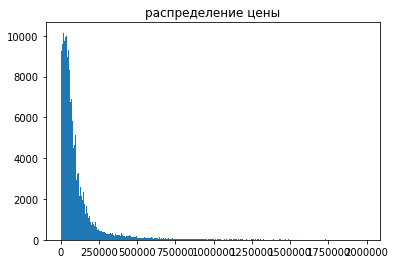

In [10]:
fig = plt.hist(df_CatFloor_DateOut.per_square_meter_price, bins=500)
t = plt.title('распределение цены')

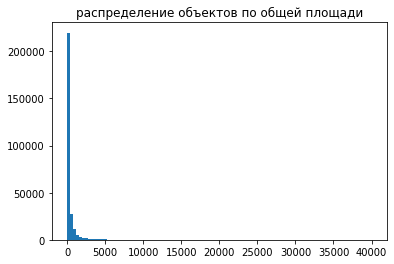

In [11]:
fig = plt.hist(df_CatFloor_DateOut.total_square, bins=100)
t = plt.title('распределение объектов по общей площади')

Это распределение напоминает логнормальное. Возьмем теперь логарифм от этих колонок.

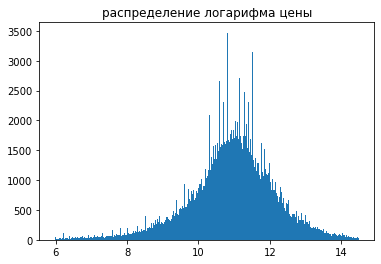

In [22]:
fig = plt.hist(np.log(df_CatFloor_DateOut.per_square_meter_price), bins=500)
t = plt.title('распределение логарифма цены')

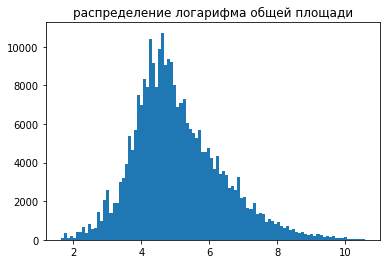

In [23]:
fig = plt.hist(np.log(df_CatFloor_DateOut.total_square), bins=100)
t = plt.title('распределение логарифма общей площади')

Поэтому, вместо цены будем тренироваться на логарифме цены, а также добавим колонку с логарифмом площади.

In [14]:
df_logSquare_CatFloor_DateOut = df_CatFloor_DateOut.merge(pd.DataFrame({'total_square_log':np.log(df_CatFloor_DateOut.total_square)}),\
              on=df_CatFloor_DateOut.index)
df_logSquare_CatFloor_DateOut = df_logSquare_CatFloor_DateOut.rename({'key_0':'id'}, axis=1)
df_logSquare_CatFloor_DateOut.index = df_logSquare_CatFloor_DateOut.id
df_logSquare_CatFloor_DateOut.drop(['id'], axis=1, inplace=True)
log_pr = df_logSquare_CatFloor_DateOut.per_square_meter_price.apply(np.log)
df_logPrice_logSquare_CatFloor_DateOut = df_logSquare_CatFloor_DateOut
df_logPrice_logSquare_CatFloor_DateOut['per_square_meter_price'] = log_pr
main_df_price1 = df_logPrice_logSquare_CatFloor_DateOut.loc[df_logSquare_CatFloor_DateOut.price_type == 1].drop(['price_type'], axis = 1)
main_df_price0 = df_logPrice_logSquare_CatFloor_DateOut.loc[df_logSquare_CatFloor_DateOut.price_type == 0].drop(['price_type'], axis = 1)

# Experiments

### cross validation 

In [15]:
def cross_validate(data, iterations, cat_features, verbose, n_cv, unused_features):
    data.drop(unused_features, axis=1, inplace=True)
    diff = set(unused_features)
    cat_features.difference_update(diff)
    
    catboost_regressor = CatBoostRegressor(iterations=iterations,cat_features=cat_features, random_seed=17, task_type=task_type)
    
    idxs = [[] for i in range(n_cv)]
    for i in range(len(data)):
        r = np.random.randint(0, n_cv)
        idxs[r].append(data.index[i])
    X_train = pd.DataFrame()
    X_test  = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test  = pd.DataFrame()
    scores = []
    feature_imp_lst = []
    for i in range(len(idxs)):
        print('Iter: ', i)
        train_idxs = []
        for idx in idxs[:i]+idxs[i+1:]:
            train_idxs+=idx
        X_train =  data.loc[train_idxs, :].drop('per_square_meter_price', axis=1)
        X_test  =  data.loc[idxs[i]].drop('per_square_meter_price', axis=1)
        y_train =  data.loc[train_idxs, :].per_square_meter_price
        y_test  =  data.loc[idxs[i], :].per_square_meter_price
        catboost_regressor.fit(X_train, y_train, verbose=verbose, plot=True)
        y_pred = catboost_regressor.predict(X_test)
        score = deviation_metric(y_test, y_pred, isLog=True)
        scores.append(score)
        feature_imp_lst.append(catboost_regressor.feature_importances_)
        print("Score: ", score)   
    print('Score: ', sum(scores)/len(scores))
    feature_imps = []
    for i in range(len(sum(feature_imp_lst)/len(feature_imp_lst))):
        feature_imps.append((X_train.columns[i], catboost_regressor.feature_importances_[i]))
    feature_imps = sorted(feature_imps, key = lambda x: x[1])
    feature_imps.reverse()
    print('Feature importances')
    print(feature_imps)

### only '1' class, log price, log total square

In [16]:
iterations=1000
task_type="CPU"
verbose=False
n_cv = 4
unused_features = ['total_square']
data = main_df_price1.copy()
cross_validate(data, iterations, cat_features, verbose, n_cv, unused_features)

# Fitting

In [17]:
iterations=1000
task_type="GPU"
verbose=False
unused_features = ['total_square']
data = main_df_price1.copy()
data.drop(unused_features, axis=1, inplace=True)
diff = set(unused_features)
cat_features.difference_update(diff)
catboost_regressor = CatBoostRegressor(iterations=iterations,cat_features=cat_features, random_seed=17, task_type=task_type)
X_train =  data.drop('per_square_meter_price', axis=1)
y_train =  data.per_square_meter_price
catboost_regressor.fit(X_train, y_train, verbose=verbose, plot=True)

# Prediction

In [18]:
test_df = pd.read_csv('data/test.csv', index_col = 'id')

In [19]:
test_df = test_df.reindex(columns=sorted(test_df.columns))

In [20]:
test_df = test_df.drop(['date'], axis = 1).copy()
test_df['floor'] = test_df['floor'].apply(str)
test_df['floor'] = test_df['floor'].apply(set_floor)
test_df['realty_type']= test_df['realty_type'].apply(str)
for col in test_df.columns:
    if col not in cat_features:
        test_df[col] = test_df[col].fillna(test_df[col].median())
    else:
        test_df[col] = test_df[col].fillna('unknown')
log_sq = test_df.total_square.apply(np.log)
test_df['total_square_log'] = log_sq 
test_df.drop(['price_type']+unused_features, axis = 1, inplace=True)
test_predict = catboost_regressor.predict(test_df)
test_predict = np.exp(test_predict)
and_df = pd.DataFrame({'per_square_meter_price':test_predict})
and_df.index = test_df.index
and_df

,per_square_meter_price
id,
COL_289284,44741.823353
COL_289305,43610.418117
COL_289318,37310.085271
COL_289354,94883.870189
COL_289399,56729.724212
...,...
COL_455089,29113.467708
COL_455212,48454.583752
COL_455261,41690.948171


In [21]:
and_df.to_csv('data/predict.csv')